In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit as cf
import os
import pandas as pd

In [2]:
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['font.size'] = 15
mpl.rcParams['errorbar.capsize'] = 3
mpl.rcParams['lines.markeredgewidth'] = 1
mpl.rcParams['axes.axisbelow'] = True

In [3]:
dcmls = lambda x : -int(floor(np.log10(abs(x))))

round_error = lambda value,rounder : np.round(value,dcmls(rounder))

def chi2_red(y,y_err,x,func,popt):
    puntos = len(y)
    params = len(popt)
    grados_lib = puntos - params - 1
    y_ajuste = func(x,*popt)
    
    chi_cuadrado = np.sum(((y-y_ajuste)/y_err)**2)
    chi_reducido = chi_cuadrado/grados_lib
    return chi_reducido

In [4]:
df = pd.read_csv('caract/mults3.csv')
V0_1 = np.mean(df.V1)
V0_2 = np.mean(df.V2)
V0_3 = np.mean(df.V3[df.V3<0.002])
print(V0_1*1000,V0_2*1000,V0_3*1000)

df = pd.read_csv('caract/3cuplas.csv')
df.V1 -= V0_1
df.V2 -= V0_2
df.V3 -= V0_3
Vc_1 = np.mean(df.V1)
Vc_2 = np.mean(df.V2)
Vc_3 = np.mean(df.V3)
dV1 = Vc_1 - Vc_2
dV3 = Vc_3 - Vc_2
print(dV1*1000,dV3*1000)

-0.24237812499999997 -0.005738416666666665 -0.0023332842105263105
0.4045866302083333 0.3296623050438596


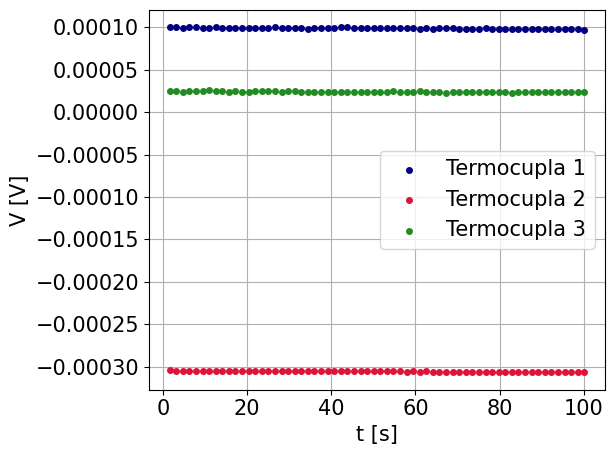

In [5]:
df = pd.read_csv('caract/3cuplas.csv')
df.V1 -= V0_1
df.V2 -= V0_2
df.V3 -= V0_3

plt.scatter(df.t,df.V1,c='navy',label='Termocupla 1')
plt.scatter(df.t,df.V2,c='crimson',label='Termocupla 2')
plt.scatter(df.t,df.V3,c='forestgreen',label='Termocupla 3')
plt.grid()
plt.legend()
plt.xlabel('t [s]')
plt.ylabel('V [V]')
plt.tight_layout()
#plt.savefig('plots/cuplas.png')

In [6]:
def open_df(file,V3=None):
    df = pd.read_csv(file)
    df.drop(df.columns[0],axis=1,inplace=True)
    df.V1 -= V0_1
    df.V1 -= dV1
    df.V2 -= V0_2
    if V3 is not None:
        df.V3 -= V0_3
        if V3 == 'T':
            df.V3 -= dV3
    return df

In [7]:
from tc import Thermocouple

termoloco = Thermocouple()

temp = lambda V : termoloco.mv_to_typek(V*1000)

def temps(Vs):
    Ts = []
    for V in Vs:
        Ts.append(temp(V))
    return np.array(Ts)

In [8]:
def open_saltos(folder,reverse=False,V3=True,weird=False):
    files = os.listdir(f'{folder}')
    names = []
    for i in range(len(files)):
        if files[i].endswith('.csv'):
            names.append(float(files[i][:-4]))
    names = np.sort(np.array(names))
    if reverse:
        for i in range(len(names)-1):
            names[i] = names[i+1]
        names[-1] = 0.0
    
    df = pd.read_csv(f'{folder}/{names[0]}.csv')
    for name in names[1:]:
        df = pd.concat([df,pd.read_csv(f'{folder}/{name}.csv')])
    if weird:
        df.drop(columns=df.columns[:2],axis=1,inplace=True)
    else:
        df.drop(columns=df.columns[:1],axis=1,inplace=True)
    df.reset_index(drop=True,inplace=True)
    df.V1 -= V0_1
    df.V2 -= V0_2
    df.V1 -= dV1
    if V3:
        df.V3 -= V0_3
    return df

              t        V1        V2
0      1.068985 -0.000407 -0.000169
1      2.113007 -0.000407 -0.000169
2      3.157798 -0.000407 -0.000169
3      4.201397 -0.000407 -0.000169
4      5.246334 -0.000407 -0.000169
..          ...       ...       ...
763  798.072867  0.000141  0.001816
764  799.117325  0.000143  0.001821
765  800.162022  0.000145  0.001825
766  801.205689  0.000147  0.001830
767  802.251452  0.000149  0.001835

[768 rows x 3 columns]


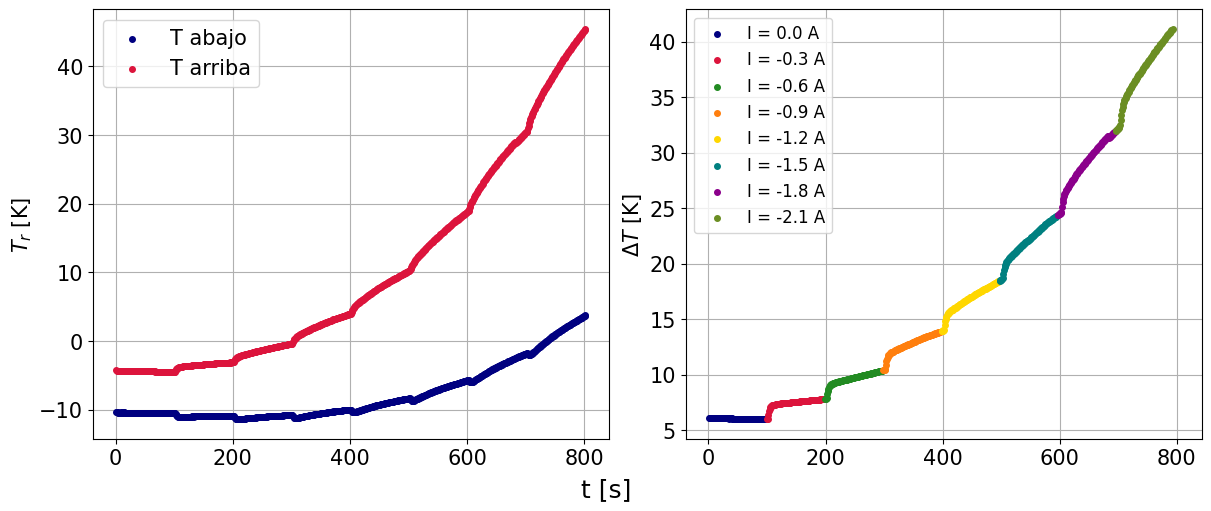

In [120]:
df = open_saltos('saltos/segundo largo neg',V3=False)

df.sort_values(df.columns[0],inplace=True)
df.reset_index(drop=True,inplace=True)
print(df)

temp1 = temps(df.V1)
temp2 = temps(df.V2)
dT = temp2 - temp1

fig,axs = plt.subplots(1,2,figsize=(12,5),sharex=True,layout='constrained')
axs = axs.flat

axs[0].scatter(df.t,temp1,c='navy',label='T abajo')
axs[0].scatter(df.t,temp2,c='crimson',label='T arriba')
axs[0].legend()
axs[0].grid()
axs[0].set_ylabel(r'$T_{r}$ [K]')

c_list = ['navy','crimson','forestgreen','tab:orange','gold','teal','darkmagenta','olivedrab']
I_list = [0.0,-0.3,-0.6,-0.9,-1.2,-1.5,-1.8,-2.1]

for i in range(len(c_list)):
    axs[1].scatter(df.t[i*95:(i+1)*95-1],dT[i*95:(i+1)*95-1],c=c_list[i],label=f'I = {I_list[i]} A')
axs[1].legend(fontsize=12)
axs[1].grid()
axs[1].set_ylabel(r'$\Delta T$ [K]')

fig.supxlabel('t [s]')

plt.savefig('plots/saltos1neg.png')

Text(0.5, 0.01, 't [s]')

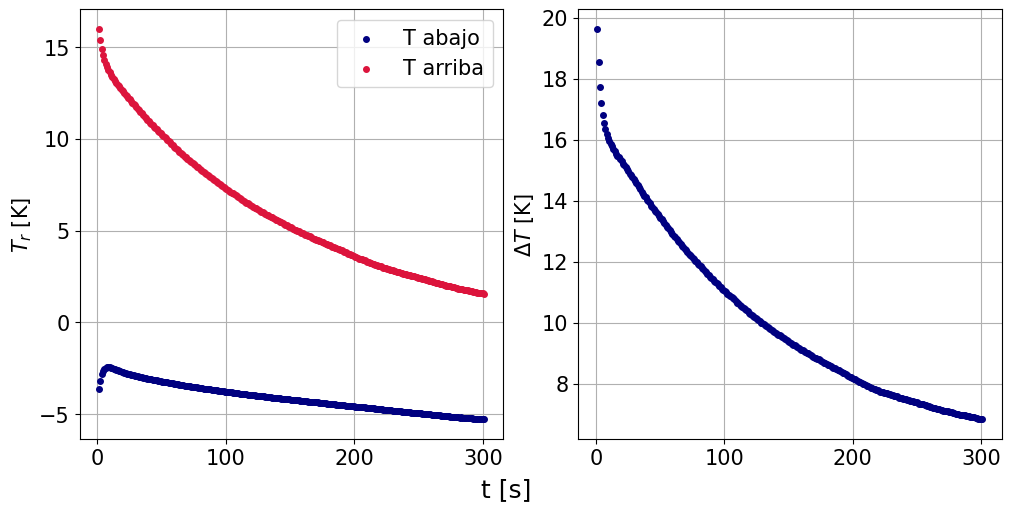

In [119]:
df = open_df('cooling.csv')

temp1 = temps(df.V1)
temp2 = temps(df.V2)

dT = temp2 - temp1

fig,axs = plt.subplots(1,2,figsize=(10,5),sharex=True,layout='constrained')
axs = axs.flat

axs[0].scatter(df.t,temp1,c='navy',label='T abajo')
axs[0].scatter(df.t,temp2,c='crimson',label='T arriba')
axs[0].legend()
axs[0].grid()
axs[0].set_ylabel(r'$T_{r}$ [K]')

axs[1].scatter(df.t,dT,c='navy')
axs[1].grid()
axs[1].set_ylabel(r'$\Delta T$ [K]')

fig.supxlabel('t [s]')

#plt.savefig('plots/cooling0.png')

                t        V1        V2        V3
0        1.516605 -0.000249 -0.000184  0.307847
1        3.039099 -0.000246 -0.000187  0.350711
2        4.557653 -0.000244 -0.000189  0.370543
3        6.078522 -0.000242 -0.000191  0.379934
4        7.592005 -0.000242 -0.000192  0.384481
...           ...       ...       ...       ...
1120  1696.780292 -0.000205 -0.000170  0.000261
1121  1698.346268 -0.000205 -0.000170  0.000264
1122  1699.916255 -0.000205 -0.000170  0.000261
1123  1701.476105 -0.000205 -0.000170  0.000260
1124  1703.036724 -0.000206 -0.000170  0.000256

[1125 rows x 4 columns]


Text(0, 0.5, 'V [V]')

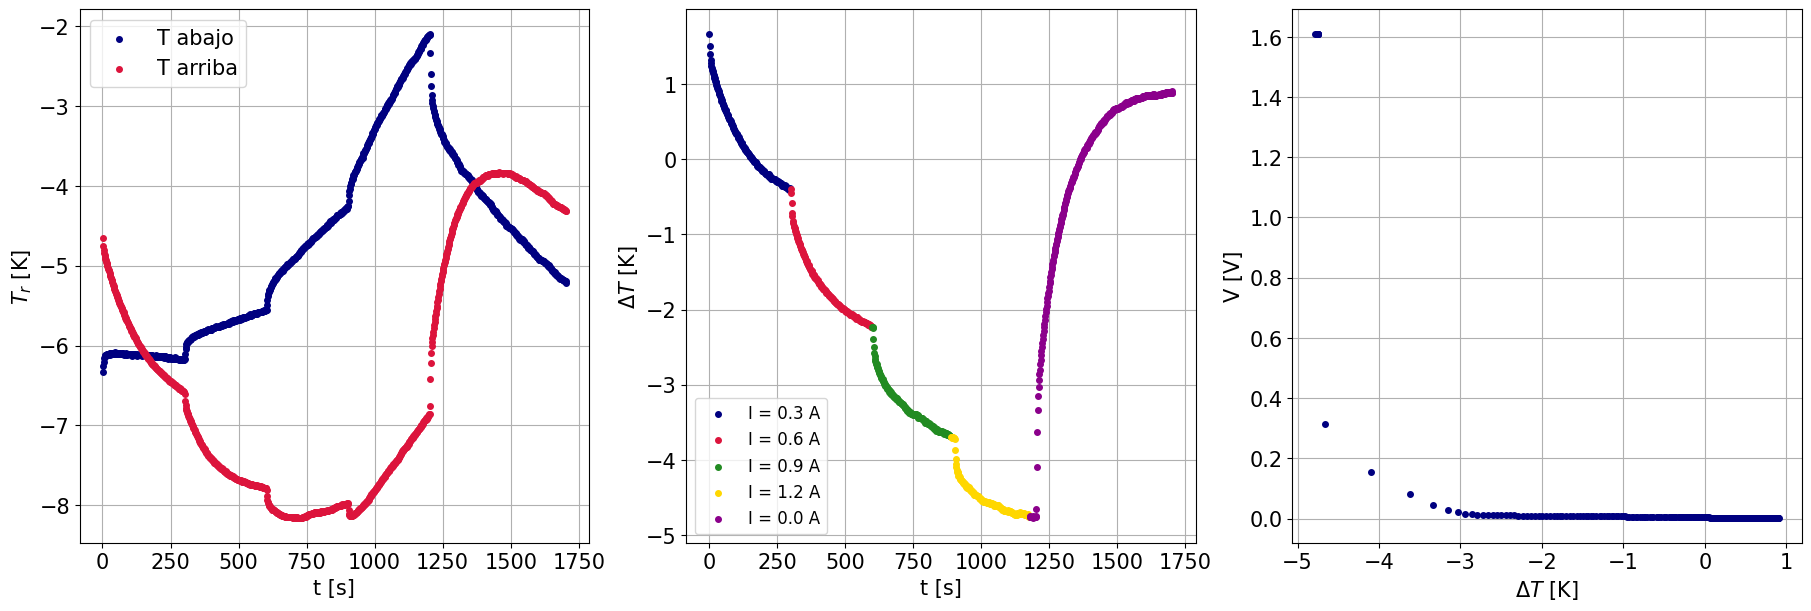

In [13]:
df = open_saltos('seebeck/saltos pos',reverse=True)

df.drop(df.columns[-1],axis=1,inplace=True)
df.sort_values(df.columns[0],inplace=True)
df.reset_index(drop=True,inplace=True)
#df.V3 = -df.V3
print(df)

temp1 = temps(df.V1)
temp2 = temps(df.V2)
dT = temp2 - temp1

fig,axs = plt.subplots(1,3,figsize=(18,6),layout='constrained')
axs = axs.flat

axs[0].scatter(df.t,temp1,c='navy',label='T abajo')
axs[0].scatter(df.t,temp2,c='crimson',label='T arriba')
axs[0].legend()
axs[0].grid()
axs[0].set_ylabel(r'$T_{r}$ [K]')
axs[0].set_xlabel('t [s]')

c_list = ['navy','crimson','forestgreen','gold','darkmagenta']
I_list = [0.3,0.6,0.9,1.2,0.0]

for i in range(len(c_list)-1):
    axs[1].scatter(df.t[i*197:(i+1)*197-1],dT[i*197:(i+1)*197-1],c=c_list[i],label=f'I = {I_list[i]} A')
axs[1].scatter(df.t[(i+1)*197-1:],dT[(i+1)*197-1:],c=c_list[i+1],label=f'I = {I_list[i+1]} A')
axs[1].legend(fontsize=12)
axs[1].grid()
axs[1].set_ylabel(r'$\Delta T$ [K]')
axs[1].set_xlabel('t [s]')

final_dT = dT[(i+1)*197-1:]
final_V3 = df.V3[(i+1)*197-1:]

axs[2].scatter(final_dT[final_V3>-0.02],final_V3[final_V3>-0.02],c='navy')
axs[2].grid()
axs[2].set_xlabel(r'$\Delta T$ [K]')
axs[2].set_ylabel('V [V]')

#plt.savefig('plots/saltos_con_off.png')

             t        V1        V2        V3
0     1.566566 -0.000271 -0.000295 -0.000339
1     3.134037 -0.000231 -0.000364 -0.000339
2     4.690718 -0.000206 -0.000415 -0.000339
3     6.258719 -0.000193 -0.000443 -0.000340
4     7.826064 -0.000185 -0.000456 -0.000340
..         ...       ...       ...       ...
72  114.148737 -0.000084 -0.000323 -0.000370
73  115.709225 -0.000083 -0.000322 -0.000369
74  117.274431 -0.000083 -0.000321 -0.000369
75  118.830497 -0.000101 -0.000320 -0.000368
76  120.394122 -0.000114 -0.000320 -0.000368

[77 rows x 4 columns]


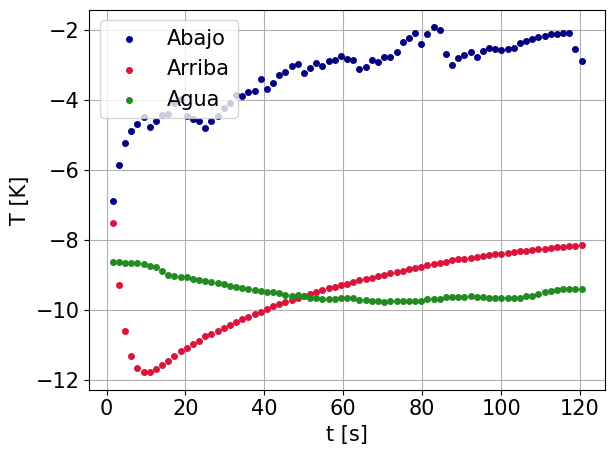

In [165]:
df = open_df('agua/120s.csv',V3='T')

print(df)

temp1 = temps(df.V1)
temp2 = temps(df.V2)
temp3 = temps(df.V3)

plt.scatter(df.t,temp1,c='navy',label='Abajo')
plt.scatter(df.t,temp2,c='crimson',label='Arriba')
plt.scatter(df.t,temp3,c='forestgreen',label='Agua')
plt.grid()
plt.legend(loc=2)
plt.xlabel('t [s]')
plt.ylabel('T [K]')
plt.tight_layout()
plt.savefig('plots/Ts_agua.png')

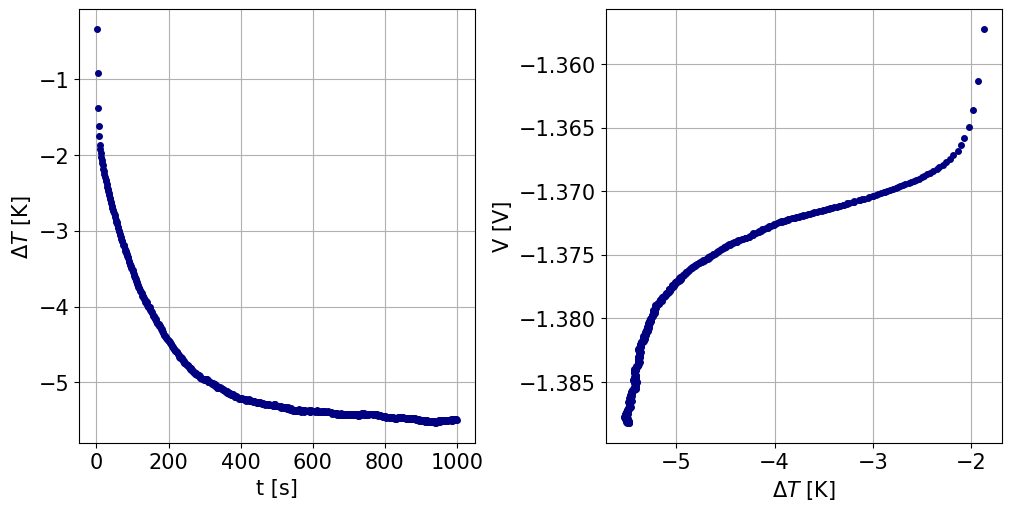

In [176]:
df = open_df('long_on.csv',V3=True)

temp1 = temps(df.V1)
temp2 = temps(df.V2)
dT = temp2-temp1

fig,axs = plt.subplots(1,2,figsize=(10,5),layout='constrained')
axs = axs.flat

axs[0].scatter(df.t,dT,c='navy')
axs[0].grid()
axs[0].set_ylabel(r'$\Delta T$ [K]')
axs[0].set_xlabel('t [s]')

axs[1].scatter(dT[df.V3<-1.35],df.V3[df.V3<-1.35],c='navy')
axs[1].grid()
axs[1].set_xlabel(r'$\Delta T$ [K]')
axs[1].set_ylabel('V [V]')
plt.savefig('plots/long_on.png')

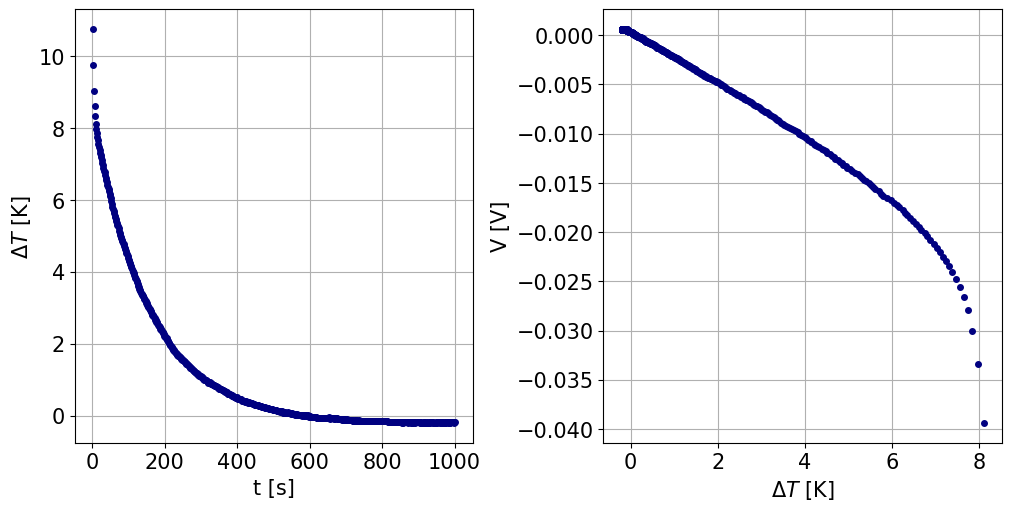

In [175]:
df = open_df('long_off.csv',V3=True)

temp1 = temps(df.V1)
temp2 = temps(df.V2)
dT = temp2-temp1

fig,axs = plt.subplots(1,2,figsize=(10,5),layout='constrained')
axs = axs.flat

axs[0].scatter(df.t,dT,c='navy')
axs[0].grid()
axs[0].set_ylabel(r'$\Delta T$ [K]')
axs[0].set_xlabel('t [s]')

axs[1].scatter(dT[df.V3>-0.05],df.V3[df.V3>-0.05],c='navy')
axs[1].grid()
axs[1].set_xlabel(r'$\Delta T$ [K]')
axs[1].set_ylabel('V [V]')
plt.savefig('plots/long_off.png')